In [983]:
from package.Time_Series_HMM import HmmTimeSeries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.stats import poisson
import warnings
warnings.filterwarnings("ignore")

In [293]:
%load_ext autoreload
%autoreload
from package.Time_Series_HMM import HmmTimeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr

yf.pdr_override()


def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 
                                                 'Close', 'Adj Close', 'Volume','LIBOR')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]

In [989]:
company='GME'
start, end = "2019-01-01", "2021-03-25"
features = ['Open', 'High', 'Low', 'Close']
GEM_data = get_financial_time_series(company, start, end, features).reset_index()
GEM_data['frac_change'] = (np.array(GEM_data['Close']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_high'] = (np.array(GEM_data['High']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_low'] = (np.array(GEM_data['Open']) - np.array(GEM_data['Low'])) / np.array(GEM_data['Open'])
GEM_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,frac_change,frac_high,frac_low
0,2019-01-02,12.45,13.18,12.42,13.07,0.049799,0.058635,0.002410
1,2019-01-03,12.98,13.26,12.69,12.97,-0.000770,0.021572,0.022342
2,2019-01-04,14.03,15.29,13.70,15.24,0.086244,0.089808,0.023521
3,2019-01-07,15.11,15.81,14.94,15.48,0.024487,0.046327,0.011251
4,2019-01-08,15.50,15.89,15.15,15.81,0.020000,0.025161,0.022581


In [990]:
HMM_features = ['frac_change','frac_high','frac_low']
HMM_stock_predictor = HmmTimeSeries(data=GEM_data, features=HMM_features,
                                    test_size=0.2,
                                    n_hidden_states=2,
                                    n_iter=1000,covariance_type='full')


HMM_stock_predictor.fit()

(array([[-0.00137772,  0.0237482 ,  0.02207075],
        [ 0.01367328,  0.07136751,  0.05031229]]),
 array([[[ 0.00069706,  0.00038267, -0.00031755],
         [ 0.00038267,  0.00037224, -0.00013116],
         [-0.00031755, -0.00013116,  0.00033492]],
 
        [[ 0.00644676,  0.00490131, -0.00209397],
         [ 0.00490131,  0.00475024, -0.00149094],
         [-0.00209397, -0.00149094,  0.00165312]]]),
 array([[0.91609461, 0.08390539],
        [0.21000984, 0.78999016]]))

In [991]:
# HMM_stock_predictor.predict()
# HMM_stock_predictor.features
# HMM_stock_predictor._possible_outcomes

In [992]:
fig = px.scatter(GEM_data, x="Date", y="frac_change", hover_data=GEM_data.columns.to_list())
fig.show()

In [1044]:
Pt_prev = HMM_stock_predictor.data.loc[:,'Close']
Pt = HMM_stock_predictor.data.loc[1:,'Close'].reset_index(drop=True)
rt = 100*(np.log(Pt) - np.log(Pt_prev[:-1]))
rt = pd.concat([pd.Series([np.nan]), rt]).reset_index(drop=True)
HMM_stock_predictor.data['return'] = rt
HMM_stock_predictor.data = HMM_stock_predictor.data.dropna().reset_index(drop=True)
HMM_stock_predictor.data.head()

,Date,Open,High,Low,Close,frac_change,frac_high,frac_low,return,cls,state
0,2019-01-04,14.03,15.290000,13.70,15.24,0.086244,0.089808,0.023521,16.128452,1,1
1,2019-01-07,15.11,15.810000,14.94,15.48,0.024487,0.046327,0.011251,1.562530,0,1
2,2019-01-08,15.50,15.890000,15.15,15.81,0.020000,0.025161,0.022581,2.109384,0,1
3,2019-01-09,15.84,16.389999,15.72,15.98,0.008838,0.034722,0.007576,1.069523,0,1
4,2019-01-10,15.74,16.000000,15.52,15.96,0.013977,0.016518,0.013977,-0.125232,0,0


In [1045]:
df_rt = HMM_stock_predictor.data.copy()
Y = df_rt['return'].values.reshape(-1,1)

L= np.arange(1,100,1)
clfs= [GMM(n,covariance_type='full').fit(Y) for n in L]
aics= np.array([clf.aic(Y) for clf in clfs])
bics= np.array([clf.bic(Y) for clf in clfs])


fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=L, y=aics,
                      mode='lines+markers',
                    name='AIC'),secondary_y=False,)

fig.add_trace(go.Scatter(x=L, y=bics,
                    mode='lines+markers',
                    name='BIC'),secondary_y=False,)

fig.add_trace(go.Scatter(x=L, y=(aics+bics),
                    mode='lines+markers',
                    name='AIC+BIC'),secondary_y=True,)

# Set x-axis title
fig.update_xaxes(title_text="Iterations")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Single</b> score", secondary_y=False)
fig.update_yaxes(title_text="<b>Sum</b> score", secondary_y=True)

fig.show()

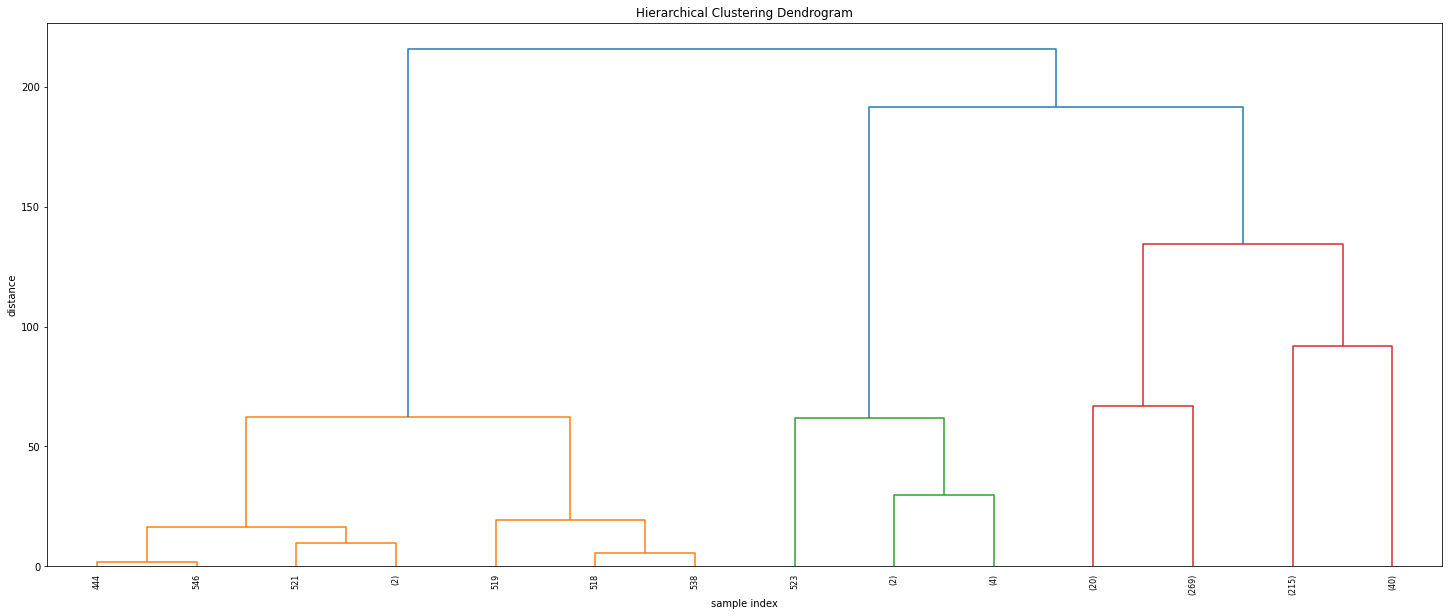

In [1046]:
from scipy.cluster import hierarchy as hac

num_of_cluster = 3

Z = hac.linkage(np.reshape(Y, (len(Y), 1)), method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level', p=num_of_cluster
)
plt.show()

In [1047]:
num_of_cluster = 3

Y = df_rt['return'].values.reshape(-1,1)
GMM_cluster = GMM(num_of_cluster,covariance_type='full').fit(Y)
df_rt['cls'] = GMM_cluster.predict(Y)
df = px.data.iris()
fig = px.scatter(df_rt, x="Date", y="return", color="cls", hover_data=df_rt.columns.to_list())
fig.show()
df_rt.groupby('cls').agg({'return': [np.min,np.max,np.mean]})

return                      
          amin       amax       mean
cls                                 
0   -36.772478  85.371637  12.824788
1   -91.629073 -41.231108 -57.988663
2   -11.709422  10.562575  -0.152025

In [1048]:
# states_rule={
#     0: [0,10],
#     1: [-10,0],
#     2: [10, 100],
#     3: [-100, -10],
# }

states_rule={
    0: [0,100],
    1: [-100,0],
}

def states_mapping(x):
    for state, rng in states_rule.items():
        if rng[0] < x <= rng[1]:
            return state
        
df_rt['state'] = df_rt['return'].map(states_mapping)
df_rt.head()

display(df_rt.groupby('state').agg({'state': [np.min,np.max,np.mean,np.std]}))

fig = px.scatter(df_rt, x="Date", y="return", color="state", hover_data=df_rt.columns.to_list())
fig.show()

fig = px.line(df_rt, x="Date", y="state", hover_data=df_rt.columns.to_list())
fig.show()

state               
       amin amax mean  std
state                     
0         0    0    0  0.0
1         1    1    1  0.0

In [1049]:
df_rt.head()

,Date,Open,High,Low,Close,frac_change,frac_high,frac_low,return,cls,state
0,2019-01-04,14.03,15.290000,13.70,15.24,0.086244,0.089808,0.023521,16.128452,0,0
1,2019-01-07,15.11,15.810000,14.94,15.48,0.024487,0.046327,0.011251,1.562530,2,0
2,2019-01-08,15.50,15.890000,15.15,15.81,0.020000,0.025161,0.022581,2.109384,2,0
3,2019-01-09,15.84,16.389999,15.72,15.98,0.008838,0.034722,0.007576,1.069523,2,0
4,2019-01-10,15.74,16.000000,15.52,15.96,0.013977,0.016518,0.013977,-0.125232,2,1


In [1050]:
%load_ext autoreload
%autoreload
from package.Time_Series_HMM import HmmTimeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1051]:
HMM_features = ['state']
HMM_stock_predictor = HmmTimeSeries(data=df_rt, features=HMM_features,
                                    n_latency_days=10,
                                    test_size=0.2,
                                    n_hidden_states=30,
                                    startprob =None,
                                    n_iter=1000,covariance_type='full',
                                    step=[40])


means, covars, transmat = HMM_stock_predictor.fit()

Fitting a model with 959 free scalar parameters with only 447 data points will result in a degenerate solution.


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


0.56

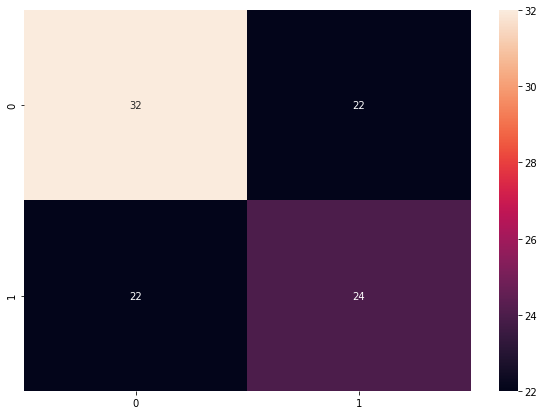

In [1053]:
predicted_state, actual_state,test_data = HMM_stock_predictor.predict_states_for_days(100, with_plot=True)

from sklearn.metrics import accuracy_score
accuracy_score(actual_state, predicted_state)

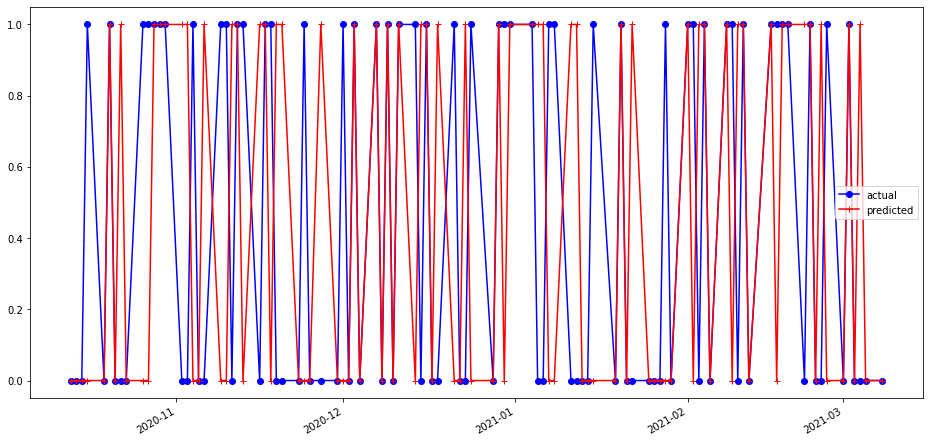

In [1054]:
fig = plt.figure(figsize=(16,8))

days = np.array(test_data['Date'], dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, actual_state, 'bo-', label="actual")
axes.plot(days, predicted_state, 'r+-', label="predicted")

fig.autofmt_xdate()

plt.legend()
plt.show()

In [1055]:
%load_ext autoreload
%autoreload
from package.Time_Series_HMM import HmmTimeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1056]:


HMM_features = ['frac_change','frac_high','frac_low']
HMM_stock_predictor = HmmTimeSeries(data=df_rt, features=HMM_features,
                                    n_latency_days=10,
                                    test_size=0.2,
                                    n_hidden_states=4,
                                    startprob =None,
                                    n_iter=1000,covariance_type='full')


HMM_stock_predictor.fit()

(array([[ 0.13078532,  0.21052129,  0.01944953],
        [-0.03649471,  0.02553836,  0.07310508],
        [-0.00417309,  0.01924352,  0.02275787],
        [ 0.03712949,  0.07312053,  0.01586795]]),
 array([[[ 1.14033574e-02,  7.66369257e-03,  7.92779116e-05],
         [ 7.66369257e-03,  6.11907576e-03,  6.21416141e-04],
         [ 7.92779116e-05,  6.21416141e-04,  1.08450011e-03]],
 
        [[ 1.84753312e-03,  5.75992031e-04, -7.92125981e-04],
         [ 5.75992031e-04,  5.50918706e-04, -9.24259920e-05],
         [-7.92125981e-04, -9.24259920e-05,  1.22577825e-03]],
 
        [[ 6.13516860e-04,  2.98431024e-04, -2.99026824e-04],
         [ 2.98431024e-04,  2.50427886e-04, -9.08070067e-05],
         [-2.99026824e-04, -9.08070067e-05,  3.39701492e-04]],
 
        [[ 1.31281245e-03,  8.70568609e-04,  1.71210003e-04],
         [ 8.70568609e-04,  9.69424753e-04,  1.14316797e-04],
         [ 1.71210003e-04,  1.14316797e-04,  3.16245235e-04]]]),
 array([[1.40232309e-01, 6.65072192e-01, 2.859

In [1057]:
predict_close,actual_close,test_data = HMM_stock_predictor.predict_states_for_days(100, with_plot=True, is_state=False)

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [1089]:
Pt_pred = predict_close[1:]
Pt_pred_prev = predict_close[:-1]
rt_pred = 100*(np.log(Pt_pred) - np.log(Pt_pred_prev))
rt_pred = np.append(np.nan, rt_pred)
predicted_state = list(map(states_mapping,rt_pred))
predicted_state = [0 if di is None else di for di in predicted_state]
actual_state = list(test_data.state)

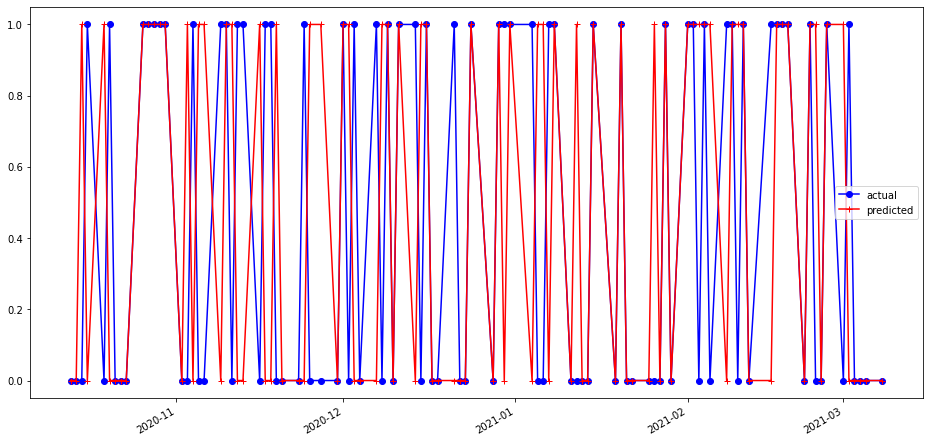

In [1084]:
fig = plt.figure(figsize=(16,8))

days = np.array(test_data['Date'], dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, actual_state, 'bo-', label="actual")
axes.plot(days, predicted_state, 'r+-', label="predicted")

fig.autofmt_xdate()

plt.legend()
plt.show()

<AxesSubplot:>

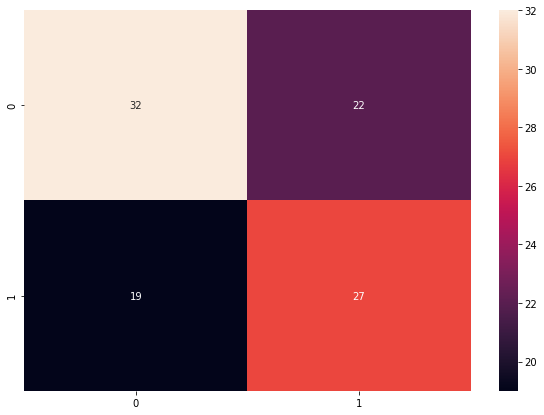

In [1088]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(actual_state,predicted_state)
df_cm = pd.DataFrame(cm, index = [i for i in set(actual_state)],
                     columns = [i for i in set(actual_state)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [1090]:
accuracy_score(actual_state, predicted_state)

0.59